<a href="https://colab.research.google.com/github/marioskyriacou/Active_Learning/blob/main/Data_Selection_Bipartite__Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Installations
!pip install numpyro
!pip install funsor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Main Libraries
import pandas as pd
import numpy as np
import numpyro
import os
import jax
import time
import pickle
import networkx as nx
import matplotlib
import seaborn as sns
import scipy.io

print(f'Pandas: {pd.__version__}')
print(f'Numpy: {np.__version__}')
print(f'Numpyro: {numpyro.__version__}')
print(f'Networkx: {nx.__version__}')
print(f'Jax: {jax.__version__} // Jax Devices:{jax.devices()[0]}')
print(f'Pickle: {pickle.format_version}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')

Pandas: 2.2.2
Numpy: 2.0.2
Numpyro: 0.19.0
Networkx: 3.5
Jax: 0.5.3 // Jax Devices:TFRT_CPU_0
Pickle: 4.0
Matplotlib: 3.10.0
Seaborn: 0.13.2


In [ ]:
# Visualization
import matplotlib.pyplot as plt

# Jax
from jax import numpy as jnp
from jax import random as jrandom
from jax import vmap
import jax.scipy.special as special
import jax.random as random


# NumpyRO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.infer import (
    MCMC,
    HMC,
    MixedHMC,
    init_to_value,
    NUTS,
    DiscreteHMCGibbs
)
from numpyro.infer import Predictive
from numpyro.distributions import constraints

## Generate a graph from the prior model
from jax import random as random_jx
from jax import lax, jit, ops
from numpyro.infer import Predictive

# table creation
from tabulate import tabulate
from tqdm import tqdm

#mount the drive so that I can read and write on files on my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def plt_deg_distr(deg, title, binned=False):
    # Plot Degree Distributions:
    # Count the degrees of each nodes for one type of nodes (A or B) -> eliminate the 0 connections
    # plot the degree distribution
    deg = deg[deg > 0]
    num_nodes = len(deg)
    freq = pd.Series(deg).value_counts().to_dict()  # Count the occurrences of each degree

    if binned == True:
        freq = [x / num_nodes for x in list(freq.values())] ## Normalize frequency values
        bins = np.exp(np.linspace(np.log(min(freq)), np.log(max(freq)), 20)) #logarithmic bins for frequency values
        sizebins = (bins[1:] - bins[:-1]) #width of each bin
        # sizebins = np.append(sizebins, 1)
        counts = np.histogram(freq, bins=bins)[0]
        freq = counts/sizebins #Normalize counts by bin size
        freq = freq/sum(freq) #Further normalize frequency so the total sums to 1

        plt.figure()
        plt.plot(bins[:-1], freq, 'bo', label='empirical')
        plt.legend()
    else:
        plt.figure()
        plt.plot(list(freq.keys()), [np.exp(np.log(x) - np.log(num_nodes)) for x in list(freq.values())], 'bo', label='deg nodes')
        plt.legend()

    plt.title(f'{title} Degree Distribuiton')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('deg')
    plt.ylabel('frequency')
    plt.grid(True)
    plt.tight_layout()

In [ ]:
def network_statistics(typeA_nodes, typeB_nodes, adj_matrix):
      # main Vairbles
      num_edges = np.sum(adj_matrix)

      #Statistics
      top_average = num_edges / typeA_nodes
      bottom_average = num_edges / typeB_nodes
      graph_average  = (2*num_edges) / (typeA_nodes + typeB_nodes)
      density = num_edges / (typeB_nodes * typeA_nodes)
      sparsity = num_edges / (typeB_nodes + typeA_nodes)**2

      # Prepare data for tabulation
      table_data = [
          ['# Top Nodes', typeB_nodes],
          ['# Bottom Nodes', typeA_nodes],
          ['# Edges', num_edges],
          ['Top average degree ', round(top_average, 4)],
          ['Bottom Average degree', round(bottom_average, 4)],
          ['Graph Average degree', round(graph_average, 4)],
          ['Density', round(density, 8)],
          ['Sparsity', round(sparsity, 8)]]

      print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt='grid'))

In [ ]:
def create_adj_matrix(df, A, B, edges=None):
    nodeA, nodeB = df[A], df[B]
    from_nodes, to_nodes = sorted(nodeA.unique()), sorted(nodeB.unique())
    print(f'From: {len(from_nodes)}\nTo: {len(to_nodes)}')

    # Index maps
    from_index = {node: i for i, node in enumerate(from_nodes)}
    to_index = {node: i for i, node in enumerate(to_nodes)}

    # Empty matrix
    adj_matrix = np.zeros((len(from_nodes), len(to_nodes)))

    # Fill the matrix with tqdm progress bar
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building adjacency matrix"):
        i = from_index[row[A]]
        j = to_index[row[B]]
        if edges is None:
            adj_matrix[i][j] = 1
        else:
            adj_matrix[i][j] = row[edges]

    print(f'\n[INFO] Adj Matrix: {adj_matrix.shape}')
    return adj_matrix, from_nodes, to_nodes

In [ ]:
def parse_wikipedia_election_txt(file_path):
    # First, count the lines for progress bar
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    votes = []
    candidate_id = None

    for line in tqdm(lines, desc="Parsing election file"):
        line = line.strip()
        if line.startswith('U'):  # Candidate line
            parts = line.split('\t')
            candidate_id = int(parts[1])
        elif line.startswith('V') and candidate_id is not None:
            parts = line.split('\t')
            vote_type = int(parts[1])
            voter_id = int(parts[2])
            votes.append((voter_id, candidate_id, vote_type))

    df = pd.DataFrame(votes, columns=['VOTER_ID', 'CANDIDATE_ID', 'VOTE'])
    return df


# Main

## BX_Books

In [ ]:
book_complite_path = '/content/drive/MyDrive/UCY Data /bx_books_data/BX-books-complete.mat' # used to find the wild animus index
BX_book_path = '/content/drive/MyDrive/UCY Data /bx_books_data/BX-books.mat' # main adj path
bx_books, bx_books_complite = scipy.io.loadmat(BX_book_path), scipy.io.loadmat(book_complite_path)

**Adj matrix analysis**

In [ ]:
print(f'BX books complete:{bx_books_complite.keys()}\nBX books: {bx_books.keys()}')

BX books complete:dict_keys(['__header__', '__version__', '__globals__', 'bxbooks'])
BX books: dict_keys(['__header__', '__version__', '__globals__', 'books', 'users', 'bipartite_graph'])


In [ ]:
books, users, graph = bx_books['books'], bx_books['users'], bx_books['bipartite_graph']
users_deg, books_deg = graph.sum(axis=1), graph.sum(axis=0)
print(f'Books:{len(books)}\nUsers:{len(users)}\nGraph:{graph.shape}')

Books:36275
Users:5064
Graph:(5064, 36275)


+-----------------------+----------------+
| Metric                |          Value |
+=======================+================+
| # Top Nodes           |  5064          |
+-----------------------+----------------+
| # Bottom Nodes        | 36275          |
+-----------------------+----------------+
| # Edges               | 49997          |
+-----------------------+----------------+
| Top average degree    |     1.3783     |
+-----------------------+----------------+
| Bottom Average degree |     9.873      |
+-----------------------+----------------+
| Graph Average degree  |  8887.33       |
+-----------------------+----------------+
| Density               |     0.00027217 |
+-----------------------+----------------+
| Sparsity              |     2.926e-05  |
+-----------------------+----------------+
################################################################################


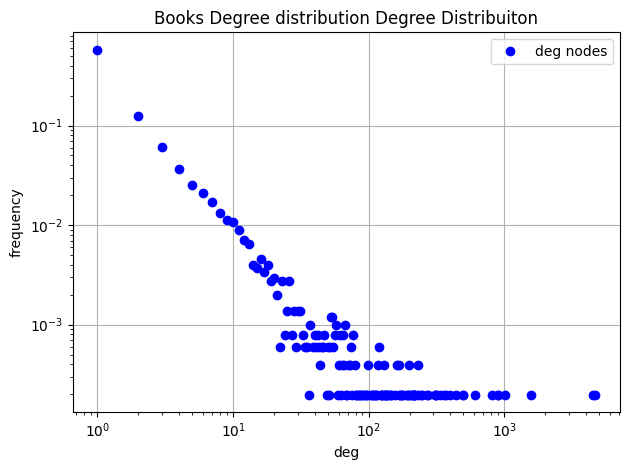

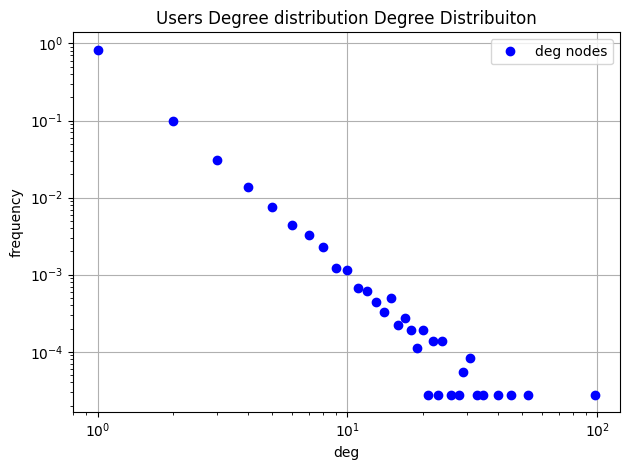

In [ ]:
network_statistics(typeA_nodes=len(books),
                   typeB_nodes=len(users),
                   adj_matrix=graph)

print('#'*80)

plt_deg_distr(deg=graph.sum(axis=1),
              title='Books Degree distribution',
              binned=False)
plt_deg_distr(deg=graph.sum(axis=0),
              title='Users Degree distribution',
              binned=False)

**How I find the ISBN**
1. Download the data/Bx-books/BX-Books.csv file
2. The file contains ISBN; Book-Title; Book-Author; Year-Of-Publication;Publisher; Image-URL-S; Image-URL-M; Image-URL-L
3. search for the wild animus book and find the corresponding ISBN
4.  Function to find the index of the book
```
wild_aniums = 0971880107
for i in range(len(mat_file['bxbooks'][0][0][0][0][0][0])):
  if mat_file['bxbooks'][0][0][0][0][0][0][i] == '0971880107':
    print(i) ## 216207
```







In [ ]:
import string
target = '971880107'

def find_wild_animus_ISBN(book_lst, ISBN):
  print(f'String punctuations: {string.punctuation}')

  for i, book in enumerate(book_lst):
    # unwrap to get the string
    if isinstance(book, (list, np.ndarray)):
        value = book[0]
        if isinstance(value, (list, np.ndarray)):
            value = value[0]
    else:
        value = book

    # Clean up formatting
    value = str(value).translate(str.maketrans('', '', string.punctuation)).replace(" ", "") # Remove all punctuation and  all whitespace characters
    if value == target:print(i)

find_wild_animus_ISBN(book_lst=books, ISBN=target)


String punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
35658


## Facebook Forum


In [ ]:
weighted_path = '/content/drive/MyDrive/UCY Data /facebook_forum_data/OF_two-mode_weightedchar.txt'
non_weighted_path = '/content/drive/MyDrive/UCY Data /facebook_forum_data/OF_longitudinal_binary.txt'

In [ ]:
weighted_forum_txt = pd.read_csv(non_weighted_path, sep=' ', header=None, names=['Date','From', 'To', 'Weight'])
non_weighted_forum_txt = pd.read_csv(weighted_path, sep=' ', header=None, names=['From', 'To', 'Weight'])

In [ ]:
forum_adj_matrix, adj_from_nodes, adj_to_nodes = create_adj_matrix(df=weighted_forum_txt,
                  A='From',
                  B='To',
                  edges='Weight')

From: 899
To: 522


Building adjacency matrix: 100%|██████████| 33720/33720 [00:02<00:00, 15410.63it/s]


[INFO] Adj Matrix: (899, 522)


In [ ]:
# # Unique nodes
# from_nodes, to_nodes = sorted(non_weighted_forum_txt['From'].unique()), sorted(non_weighted_forum_txt['To'].unique())
# print(f'From:{len(from_nodes)}\nTo:{len(to_nodes)}')

# # Index maps
# from_index = {node: i for i, node in enumerate(from_nodes)}
# to_index = {node: i for i, node in enumerate(to_nodes)}

# # empty matrix
# forum_adj_matrix = np.zeros((len(from_nodes), len(to_nodes)))

# # Fill the matrix
# for _, row in non_weighted_forum_txt.iterrows():
#     i = from_index[row['From']]
#     j = to_index[row['To']]
#     forum_adj_matrix[i][j] = int(row['Weight'])


# print(f'Adj Matrix:{forum_adj_matrix.shape}')

Delete rows and columns with no conection

In [ ]:
# # Identify non-zero rows and columns
# non_zero_rows = ~np.all(forum_adj_matrix == 0, axis=1)
# non_zero_cols = ~np.all(forum_adj_matrix == 0, axis=0)

# # Filter the matrix
# cleaned_matrix = forum_adj_matrix[non_zero_rows][:, non_zero_cols]

# # binary the adj matrix
# binary_adj = (forum_adj_matrix > 0).astype(int)

+-----------------------+---------------+
| Metric                |         Value |
+=======================+===============+
| # Top Nodes           |  522          |
+-----------------------+---------------+
| # Bottom Nodes        |  899          |
+-----------------------+---------------+
| # Edges               | 7089          |
+-----------------------+---------------+
| Top average degree    |    7.8854     |
+-----------------------+---------------+
| Bottom Average degree |   13.5805     |
+-----------------------+---------------+
| Graph Average degree  |  660.49       |
+-----------------------+---------------+
| Density               |    0.0151062  |
+-----------------------+---------------+
| Sparsity              |    0.00351073 |
+-----------------------+---------------+
################################################################################


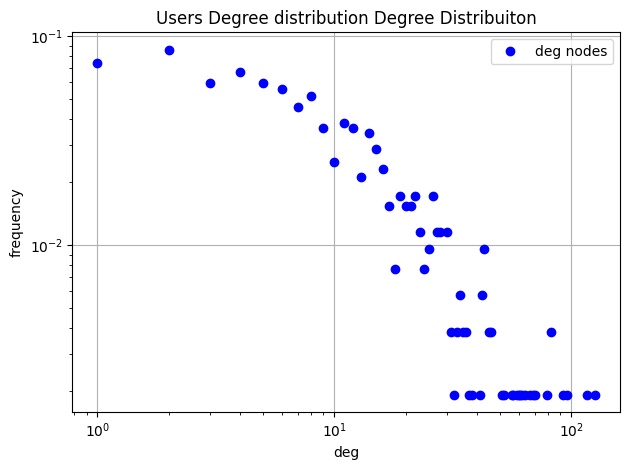

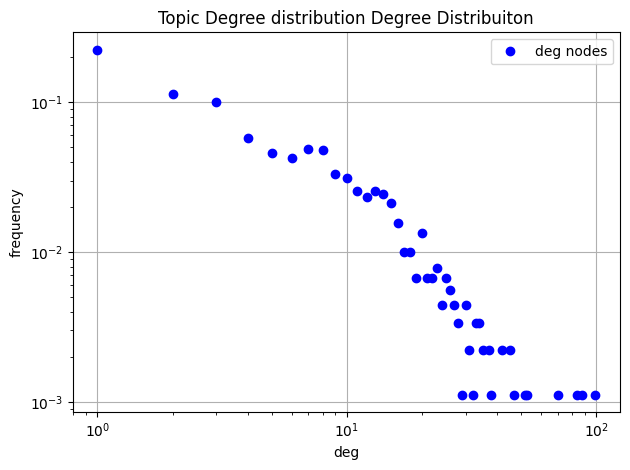

In [ ]:
network_statistics(typeA_nodes=len(adj_from_nodes),
                   typeB_nodes=len(adj_to_nodes),
                   adj_matrix=forum_adj_matrix)

print('#'*80)

plt_deg_distr(deg=forum_adj_matrix.sum(axis=0),
              title='Users Degree distribution',
              binned=False)

plt_deg_distr(deg=forum_adj_matrix.sum(axis=1),
              title='Topic Degree distribution',
              binned=False)

## IMDB

**Given from the Page**\
number of rows	428,440\
number of columns	896,308\
nonzeros	3,782,463

In [ ]:
IMDB_path = '/content/drive/MyDrive/UCY Data /IMDB.mat'
IMDB = scipy.io.loadmat(IMDB_path)
IMDB.keys()


dict_keys(['__header__', '__version__', '__globals__', 'Problem'])

In [ ]:
IMDB['Problem'][0][0][6]

array([[(array([[ 1],
               [ 2],
               [99],
               ...,
               [ 4],
               [ 1],
               [99]], dtype=uint8), array([[2004],
               [2005],
               [2002],
               ...,
               [2002],
               [1983],
               [1958]], dtype=uint16), array(['Drama      ', 'Short      ', 'Documentary', 'Comedy     ',
               'Western    ', 'Family     ', 'Mystery    ', 'Thriller   ',
               '           ', 'Music      ', 'Crime      ', 'Sci-Fi     ',
               'Horror     ', 'War        ', 'Fantasy    ', 'Romance    ',
               'Adventure  ', 'Animation  ', 'Action     ', 'Musical    ',
               'Film-Noir  ', '           ', '           ', '           ',
               '           ', '           ', '           ', '           ',
               '           ', '           ', '           ', '           ',
               '           ', '           ', '           ', '           ',
     

In [ ]:
len(IMDB['Problem'][0][0][6][0][0][0]), len(IMDB['Problem'][0][0][6][0][0][4]), len(IMDB['Problem'][0][0][6][0][0][6])

(428440, 896308)

In [ ]:
len(np.unique(IMDB['Problem'][0][0][6][0][0][4]))

10

## MOOC Dataset Details

In [ ]:
mooc_path = '/content/drive/MyDrive/UCY Data /mooc_actions.txt'
mooc_txt = pd.read_csv(mooc_path, sep='\t',  usecols=["USERID", "TARGETID", "TIMESTAMP"])
mooc_txt = mooc_txt.drop(columns=["TIMESTAMP"])


In [ ]:
mooc_adj_matrix, mooc_adj_from_nodes, mooc_adj_to_nodes = create_adj_matrix(df=mooc_txt, A="USERID", B="TARGETID", edges=None)

From: 7047
To: 97


Building adjacency matrix: 100%|██████████| 411749/411749 [00:29<00:00, 13838.10it/s]


[INFO] Adj Matrix: (7047, 97)


In [ ]:
#np.unique(mooc_adj_matrix.sum(axis=0), return_counts=True)

+-----------------------+-----------------+
| Metric                |           Value |
+=======================+=================+
| # Top Nodes           |     97          |
+-----------------------+-----------------+
| # Bottom Nodes        |   7047          |
+-----------------------+-----------------+
| # Edges               | 178443          |
+-----------------------+-----------------+
| Top average degree    |     25.3218     |
+-----------------------+-----------------+
| Bottom Average degree |   1839.62       |
+-----------------------+-----------------+
| Graph Average degree  |    191.366      |
+-----------------------+-----------------+
| Density               |      0.26105    |
+-----------------------+-----------------+
| Sparsity              |      0.00349636 |
+-----------------------+-----------------+
################################################################################


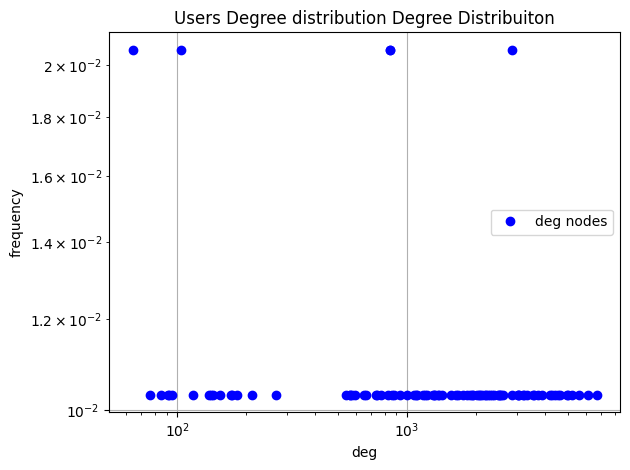

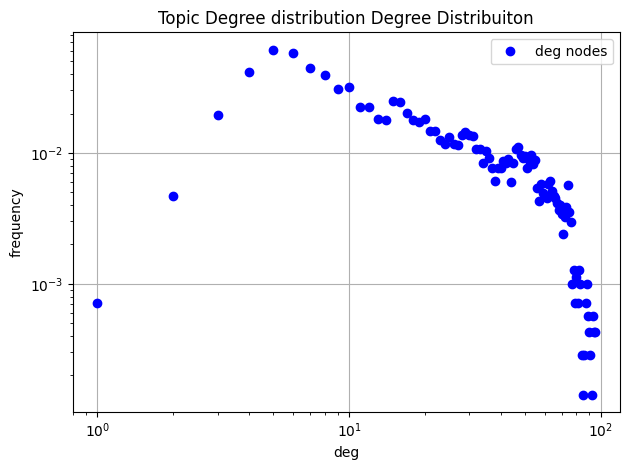

In [ ]:
network_statistics(typeA_nodes=len(mooc_adj_from_nodes),
                   typeB_nodes=len(mooc_adj_to_nodes),
                   adj_matrix=mooc_adj_matrix)

print('#'*80)

plt_deg_distr(deg=mooc_adj_matrix.sum(axis=0),
              title='Users Degree distribution',
              binned=False)

plt_deg_distr(deg=mooc_adj_matrix.sum(axis=1),
              title='Topic Degree distribution',
              binned=False)

## WikiElections

In [ ]:
wiki_path = '/content/drive/MyDrive/UCY Data /wikiElec.txt'
wiki_election = parse_wikipedia_election_txt(file_path=wiki_path)

Parsing election file: 100%|██████████| 128010/128010 [00:00<00:00, 202255.78it/s]


In [ ]:
wiki_adj_matrix, wiki_adj_from_nodes, wiki_adj_to_nodes = create_adj_matrix(df=wiki_election,
                                                                            A='VOTER_ID',
                                                                            B='CANDIDATE_ID',
                                                                            edges='VOTE')

From: 6210
To: 2391


Building adjacency matrix: 100%|██████████| 114040/114040 [00:06<00:00, 17923.93it/s]


[INFO] Adj Matrix: (6210, 2391)


+-----------------------+-----------------+
| Metric                |           Value |
+=======================+=================+
| # Top Nodes           |   2391          |
+-----------------------+-----------------+
| # Bottom Nodes        |   6210          |
+-----------------------+-----------------+
| # Edges               | 103591          |
+-----------------------+-----------------+
| Top average degree    |     16.6813     |
+-----------------------+-----------------+
| Bottom Average degree |     43.3254     |
+-----------------------+-----------------+
| Graph Average degree  |     24.0881     |
+-----------------------+-----------------+
| Density               |      0.00697671 |
+-----------------------+-----------------+
| Sparsity              |      0.00140031 |
+-----------------------+-----------------+
################################################################################


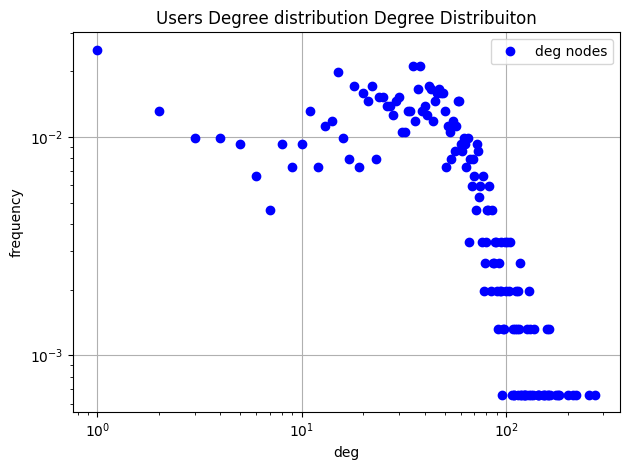

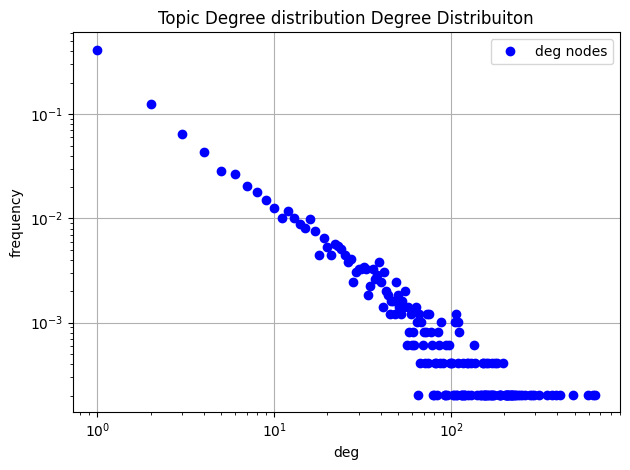

In [ ]:
network_statistics(typeA_nodes=len(wiki_adj_from_nodes),
                   typeB_nodes=len(wiki_adj_to_nodes),
                   adj_matrix=abs(wiki_adj_matrix))

print('#'*80)

plt_deg_distr(deg=wiki_adj_matrix.sum(axis=0),
              title='Users Degree distribution',
              binned=False)

plt_deg_distr(deg=wiki_adj_matrix.sum(axis=1),
              title='Topic Degree distribution',
              binned=False)

## BX Books NO wild animus


In [ ]:
bx_books_no_wildanimus_path = '/content/drive/MyDrive/UCY Data /bx_books_data/meta_data_no wild_animus/adj_matrix.mat'
books_metadata_path = '/content/drive/MyDrive/UCY Data /bx_books_data/meta_data_no wild_animus/books.mat'
readers_metadata_path = '/content/drive/MyDrive/UCY Data /bx_books_data/meta_data_no wild_animus/readers.mat'


In [ ]:
bx_books_adj_matrix = scipy.io.loadmat(bx_books_no_wildanimus_path)
bx_books_books = scipy.io.loadmat(books_metadata_path)
bx_books_readers = scipy.io.loadmat(readers_metadata_path)

print(f'adj matrix:{bx_books_adj_matrix.keys()}\nbooks:{bx_books_books.keys()}\nreaders:{bx_books_readers.keys()}')

adj matrix:dict_keys(['__header__', '__version__', '__globals__', 'G'])
books:dict_keys(['__header__', '__version__', '__globals__', 'books'])
readers:dict_keys(['__header__', '__version__', '__globals__', 'readers'])


**Adj Matrix Statistics**

In [ ]:
bx_books_adj = bx_books_adj_matrix['G'].toarray()
readers, books = bx_books_adj.shape[0],  bx_books_adj.shape[1]

+-----------------------+---------------+
| Metric                |         Value |
+=======================+===============+
| # Top Nodes           | 39524         |
+-----------------------+---------------+
| # Bottom Nodes        |  9647         |
+-----------------------+---------------+
| # Edges               | 69776         |
+-----------------------+---------------+
| Top average degree    |     7.2329    |
+-----------------------+---------------+
| Bottom Average degree |     1.7654    |
+-----------------------+---------------+
| Graph Average degree  |     2.8381    |
+-----------------------+---------------+
| Density               |     0.000183  |
+-----------------------+---------------+
| Sparsity              |     2.886e-05 |
+-----------------------+---------------+
################################################################################


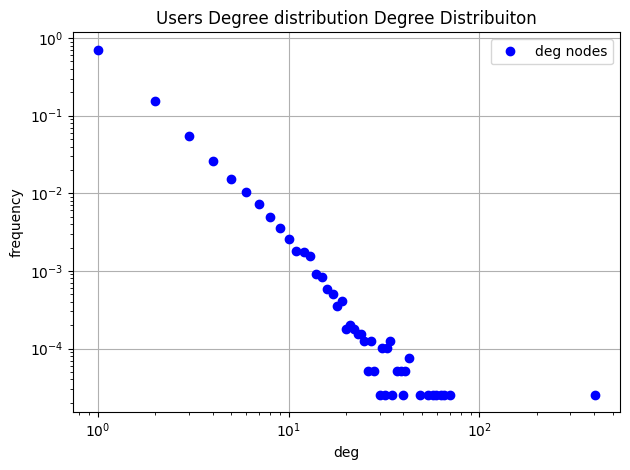

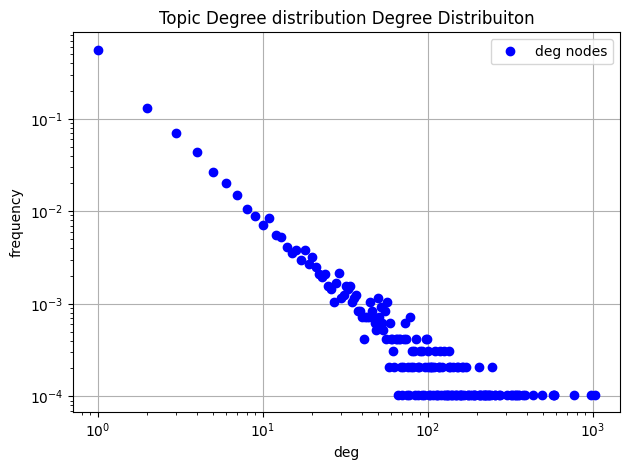

In [ ]:
network_statistics(typeA_nodes=readers,
                   typeB_nodes=books,
                   adj_matrix=bx_books_adj)

print('#'*80)

plt_deg_distr(deg=bx_books_adj.sum(axis=0),
              title='Users Degree distribution',
              binned=False)

plt_deg_distr(deg=bx_books_adj.sum(axis=1),
              title='Topic Degree distribution',
              binned=False)

**Sub Data**

In [ ]:
#find readers age and country
readers_age = bx_books_readers['readers'][0][0][2]
readers_country = bx_books_readers['readers'][0][0][3][0]

In [ ]:
sub_fraction = 0.025
num_readers_subset = int(readers*sub_fraction)

In [ ]:
rng = np.random.default_rng()
random_reader_indices = rng.choice(readers, size=num_readers_subset, replace=False)

In [ ]:
sub_data = bx_books_adj[random_reader_indices ,  :]
sub_readers, sub_books = sub_data.shape[0], sub_data.shape[1]

In [ ]:
books_readed_indx = [i for i, row in enumerate(sub_data.T) if np.sum(row) > 0]
print(f'books readed at least from one reader: {len(books_readed_indx)}')

books readed at least from one reader: 1504


In [ ]:
sub_data.shape

(241, 39524)

In [ ]:
sub_data = sub_data[:,np.any(sub_data, axis=0)]
sub_data.shape

(241, 1504)

In [ ]:
sum(sub_data).sum()

np.uint64(1543)

In [ ]:
countries, counts = np.unique(readers_country[random_reader_indices], return_counts=True)
table_data = list(zip(countries, counts))
headers = ["Countries", "Counts"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+--------------------+----------+
| Countries          |   Counts |
+====================+==========+
| ['france']         |       14 |
+--------------------+----------+
| ['germany']        |       96 |
+--------------------+----------+
| ['spain']          |       62 |
+--------------------+----------+
| ['united kingdom'] |       69 |
+--------------------+----------+


**sub data analytics**

In [ ]:
sub_readers, sub_books = sub_data.shape[0], sub_data.shape[1]

+-----------------------+---------------+
| Metric                |         Value |
+=======================+===============+
| # Top Nodes           | 1504          |
+-----------------------+---------------+
| # Bottom Nodes        |  241          |
+-----------------------+---------------+
| # Edges               | 1543          |
+-----------------------+---------------+
| Top average degree    |    6.4025     |
+-----------------------+---------------+
| Bottom Average degree |    1.0259     |
+-----------------------+---------------+
| Graph Average degree  |    1.7685     |
+-----------------------+---------------+
| Density               |    0.00425697 |
+-----------------------+---------------+
| Sparsity              |    0.00050673 |
+-----------------------+---------------+
################################################################################


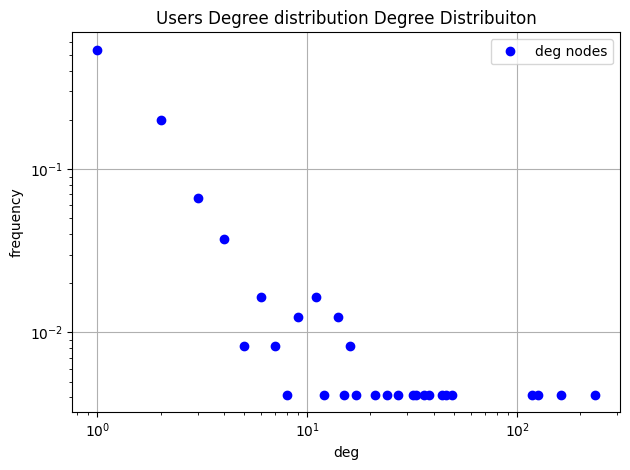

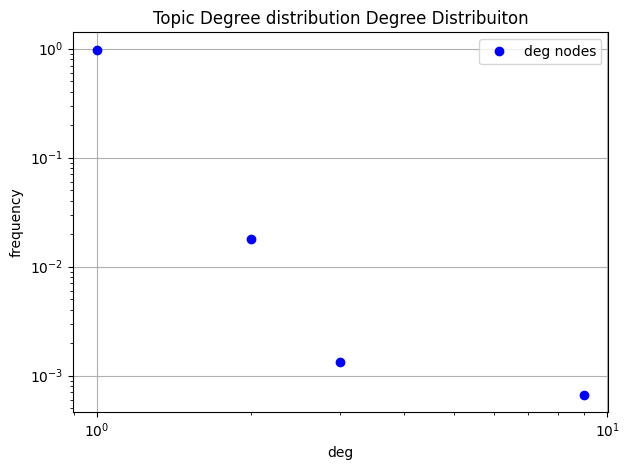

In [ ]:
network_statistics(typeA_nodes=sub_readers,
                   typeB_nodes=sub_books,
                   adj_matrix=sub_data)

print('#'*80)
plt_deg_distr(deg=sub_data.sum(axis=1),
              title='Users Degree distribution',
              binned=False)

plt_deg_distr(deg=sub_data.sum(axis=0),
              title='Topic Degree distribution',
              binned=False)

All the adj matrix

In [ ]:

def unwrap(item):
    """Recursively unwrap nested arrays to extract scalars or lists"""
    while isinstance(item, (np.ndarray, list)) and item.size == 1:
        item = item.item()
    return item

def void_to_clean_dict(void_obj):
    result = {}
    for field in void_obj.dtype.names:
        value = void_obj[field]

        # Special handling for structured nested arrays
        if isinstance(value, np.ndarray):
            if value.dtype == object:
                # Flatten and unwrap each item
                flat_list = []
                for row in value:
                    unwrapped = unwrap(row)
                    if isinstance(unwrapped, (np.ndarray, list)):
                        # Possibly country list or multi-element
                        flat_list.append([unwrap(x) for x in unwrapped])
                    else:
                        flat_list.append(unwrapped)
                result[field] = flat_list
            else:
                result[field] = value.tolist()
        else:
            result[field] = unwrap(value)

    return result

In [ ]:
readers_dict = void_to_clean_dict(bx_books_readers['readers'][0, 0])

##MoviesLen

In [ ]:
path = '/content/drive/MyDrive/UCY Data /Movieslen/ratings.csv'
movies_df = pd.read_csv(path)

In [ ]:
adj_matrix, from_nodes, to_nodes = create_adj_matrix(df=movies_df,
                  A='userId',
                  B='movieId',
                  edges=None)

From: 610
To: 9724


Building adjacency matrix: 100%|██████████| 100836/100836 [00:04<00:00, 22662.91it/s]


[INFO] Adj Matrix: (610, 9724)


+-----------------------+-----------------+
| Metric                |           Value |
+=======================+=================+
| # Top Nodes           |   9724          |
+-----------------------+-----------------+
| # Bottom Nodes        |    610          |
+-----------------------+-----------------+
| # Edges               | 100836          |
+-----------------------+-----------------+
| Top average degree    |    165.305      |
+-----------------------+-----------------+
| Bottom Average degree |     10.3698     |
+-----------------------+-----------------+
| Graph Average degree  |     19.5154     |
+-----------------------+-----------------+
| Density               |      0.0169997  |
+-----------------------+-----------------+
| Sparsity              |      0.00094423 |
+-----------------------+-----------------+
################################################################################


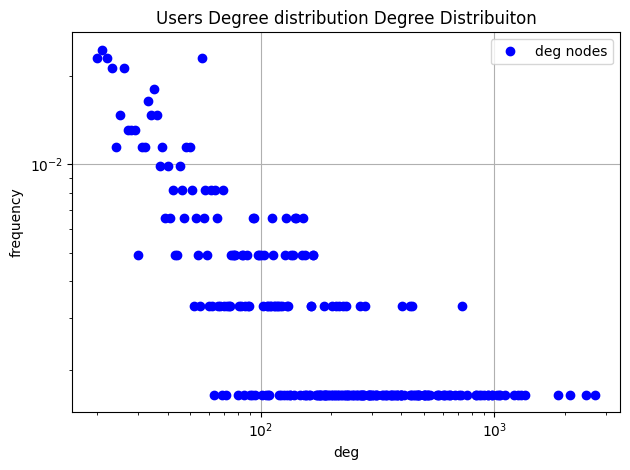

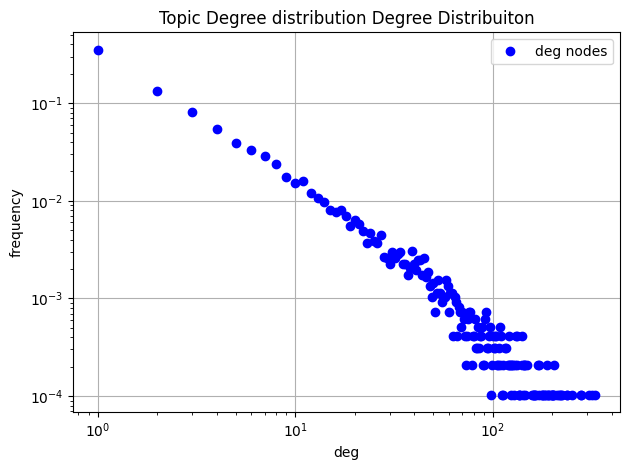

In [ ]:
network_statistics(typeA_nodes=len(from_nodes),
                   typeB_nodes=len(to_nodes),
                   adj_matrix=adj_matrix)

print('#'*80)
plt_deg_distr(deg=adj_matrix.sum(axis=1),
              title='Users Degree distribution',
              binned=False)

plt_deg_distr(deg=adj_matrix.sum(axis=0),
              title='Topic Degree distribution',
              binned=False)

## Boards and Gender

In [ ]:
year_df = pd.DataFrame(columns=['Company', 'Director'])
main_path = '/content/drive/MyDrive/UCY Data /Boards_and_Gender/'
for i, fname in enumerate(os.listdir(main_path)):
  file_pat = os.path.join(main_path, fname)
  month_df = pd.read_csv(file_pat, header = None, delimiter = ' ')
  month_df.columns = ['Company', 'Director']
  print(f'>>> Month {i}:{month_df.shape}')
  year_df = pd.concat([year_df, month_df], axis=0, ignore_index=True)

print(f'>>> Year:{year_df.shape}')
year_df = year_df.sort_values(by=['Company'])

>>> Month 0:(1143, 2)
>>> Month 1:(1184, 2)
>>> Month 2:(1303, 2)
>>> Month 3:(1158, 2)
>>> Month 4:(1178, 2)
>>> Month 5:(1303, 2)
>>> Month 6:(1261, 2)
>>> Month 7:(1151, 2)
>>> Month 8:(1221, 2)
>>> Month 9:(1279, 2)
>>> Month 10:(1230, 2)
>>> Month 11:(1297, 2)
>>> Month 12:(1245, 2)
>>> Month 13:(1208, 2)
>>> Month 14:(1236, 2)
>>> Month 15:(1130, 2)
>>> Month 16:(1252, 2)
>>> Month 17:(1220, 2)
>>> Month 18:(1320, 2)
>>> Month 19:(1148, 2)
>>> Month 20:(1319, 2)
>>> Month 21:(1212, 2)
>>> Month 22:(1244, 2)
>>> Month 23:(1315, 2)
>>> Year:(29557, 2)


In [ ]:
boards_adj_matrix, company_nodes, director_nodes  = create_adj_matrix(df=year_df,
                                                                      A='Company',
                                                                      B='Director',
                                                                      edges=None)

From: 250
To: 1641


Building adjacency matrix: 100%|██████████| 29557/29557 [00:03<00:00, 7435.11it/s] 


[INFO] Adj Matrix: (250, 1641)


+-----------------------+---------------+
| Metric                |         Value |
+=======================+===============+
| # Top Nodes           | 1641          |
+-----------------------+---------------+
| # Bottom Nodes        |  250          |
+-----------------------+---------------+
| # Edges               | 1912          |
+-----------------------+---------------+
| Top average degree    |    7.648      |
+-----------------------+---------------+
| Bottom Average degree |    1.1651     |
+-----------------------+---------------+
| Graph Average degree  |    2.0222     |
+-----------------------+---------------+
| Density               |    0.00466057 |
+-----------------------+---------------+
| Sparsity              |    0.00053469 |
+-----------------------+---------------+
################################################################################


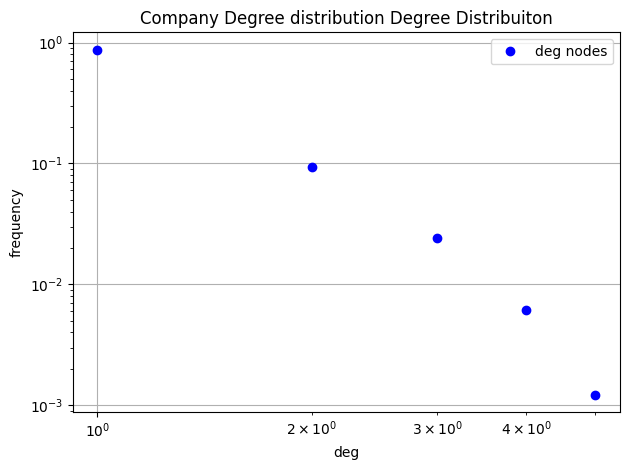

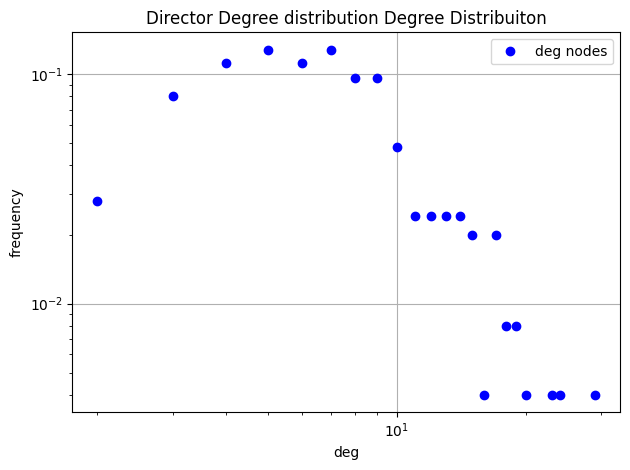

In [ ]:
network_statistics(typeA_nodes=len(company_nodes),
                   typeB_nodes=len(director_nodes),
                   adj_matrix=boards_adj_matrix)

print('#'*80)

plt_deg_distr(deg=boards_adj_matrix.sum(axis=0),
              title='Company Degree distribution',
              binned=False)

plt_deg_distr(deg=boards_adj_matrix.sum(axis=1),
              title='Director Degree distribution',
              binned=False)

## Crime - Data

In [ ]:
import tarfile
import pandas as pd

In [ ]:
import tarfile
import pandas as pd
import os

file_path = "/content/download.tsv.moreno_crime.tar.bz2"
output_dir = "/content/moreno_csvs"
os.makedirs(output_dir, exist_ok=True)

with tarfile.open(file_path, "r:bz2") as tar:
    members = tar.getmembers()
    for m in members:
        if m.isfile():
            f = tar.extractfile(m)
            if f is None:
                continue
            try:
                df = pd.read_csv(f, sep="\t", header=None, engine="python")
                out_name = os.path.basename(m.name) + ".csv"
                out_path = os.path.join(output_dir, out_name)
                df.to_csv(out_path, index=False)
                print(f"Converted {m.name} -> {out_path}, shape={df.shape}")
            except Exception as e:
                print(f"Skipping {m.name}: {e}")


Converted moreno_crime/meta.moreno_crime_crime -> /content/moreno_csvs/meta.moreno_crime_crime.csv, shape=(9, 1)
Skipping moreno_crime/README.moreno_crime: Expected 1 fields in line 36, saw 2
Converted moreno_crime/rel.moreno_crime_crime.person.role -> /content/moreno_csvs/rel.moreno_crime_crime.person.role.csv, shape=(1476, 1)
Converted moreno_crime/ent.moreno_crime_crime.person.sex -> /content/moreno_csvs/ent.moreno_crime_crime.person.sex.csv, shape=(829, 1)
Converted moreno_crime/ent.moreno_crime_crime.person.name -> /content/moreno_csvs/ent.moreno_crime_crime.person.name.csv, shape=(829, 1)
Converted moreno_crime/out.moreno_crime_crime -> /content/moreno_csvs/out.moreno_crime_crime.csv, shape=(1478, 1)


In [ ]:
paths = ['/content/moreno_csvs/ent.moreno_crime_crime.person.name.csv',
'/content/moreno_csvs/ent.moreno_crime_crime.person.sex.csv',
'/content/moreno_csvs/meta.moreno_crime_crime.csv',
'/content/moreno_csvs/out.moreno_crime_crime.csv',
'/content/moreno_csvs/rel.moreno_crime_crime.person.role.csv']



In [ ]:
bn = pd.read_csv('/content/moreno_csvs/out.moreno_crime_crime.csv',
                 sep="\t", header=None, comment="%", engine="python")

In [ ]:
bn = bn.drop(0)
bn = bn[0].str.split(" ", expand=True)
bn.columns = ["Person_Name", "Crime_events", 'col3']
bn = bn.drop(columns =['col3'])

In [ ]:
len(bn.Person_Name.unique())+ len(bn.Crime_events.unique()), bn.shape

(1380, (1476, 2))

In [ ]:
crime_adj_matrix, adj_from_nodes, adj_to_nodes = create_adj_matrix(df=bn,
                  A='Person_Name',
                  B='Crime_events',
                  edges=None)

From: 829
To: 551


Building adjacency matrix: 100%|██████████| 1476/1476 [00:00<00:00, 22102.55it/s]


[INFO] Adj Matrix: (829, 551)


+-----------------------+---------------+
| Metric                |         Value |
+=======================+===============+
| # Top Nodes           |  551          |
+-----------------------+---------------+
| # Bottom Nodes        |  829          |
+-----------------------+---------------+
| # Edges               | 1476          |
+-----------------------+---------------+
| Top average degree    |    1.7805     |
+-----------------------+---------------+
| Bottom Average degree |    2.6788     |
+-----------------------+---------------+
| Graph Average degree  |    2.1391     |
+-----------------------+---------------+
| Density               |    0.00323132 |
+-----------------------+---------------+
| Sparsity              |    0.00077505 |
+-----------------------+---------------+
################################################################################


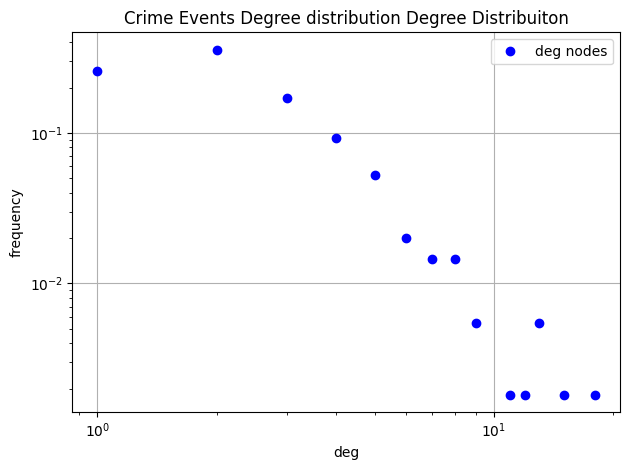

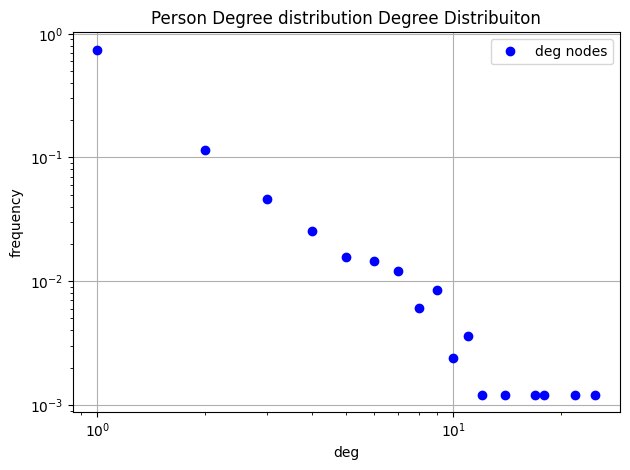

In [ ]:
network_statistics(typeA_nodes=len(adj_from_nodes),
                   typeB_nodes=len(adj_to_nodes),
                   adj_matrix=crime_adj_matrix)

print('#'*80)

plt_deg_distr(deg=crime_adj_matrix.sum(axis=0),
              title='Crime Events Degree distribution',
              binned=False)

plt_deg_distr(deg=crime_adj_matrix.sum(axis=1),
              title='Person Degree distribution',
              binned=False)

## Mamaliam various-host interaction

In [ ]:
virus_host = pd.read_csv('/content/associations.csv')

In [ ]:
print(f'Edges:{virus_host.shape}\nVirusNameCorrected:{len(virus_host.vVirusNameCorrected.unique())},\nHostNameFinal:{len(virus_host.hHostNameFinal.unique())}')

Edges:(2805, 6)
VirusNameCorrected:586,
HostNameFinal:754


In [ ]:
varius_host_adj_matrix, adj_from_nodes, adj_to_nodes = create_adj_matrix(df=virus_host,
                  A='vVirusNameCorrected',
                  B='hHostNameFinal',
                  edges=None)

NameError: name 'create_adj_matrix' is not defined

In [ ]:
host_various

In [ ]:
len(varius_host_adj_matrix.sum(axis=0))

754

+-----------------------+---------------+
| Metric                |         Value |
+=======================+===============+
| # Top Nodes           |  754          |
+-----------------------+---------------+
| # Bottom Nodes        |  586          |
+-----------------------+---------------+
| # Edges               | 2799          |
+-----------------------+---------------+
| Top average degree    |    4.7765     |
+-----------------------+---------------+
| Bottom Average degree |    3.7122     |
+-----------------------+---------------+
| Graph Average degree  |    4.1776     |
+-----------------------+---------------+
| Density               |    0.00633482 |
+-----------------------+---------------+
| Sparsity              |    0.00155881 |
+-----------------------+---------------+
################################################################################


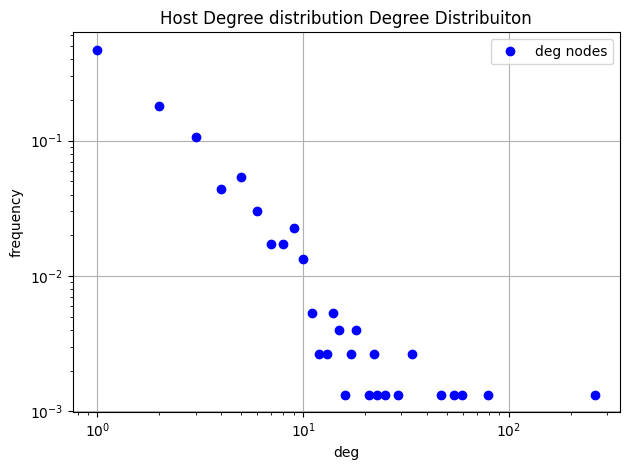

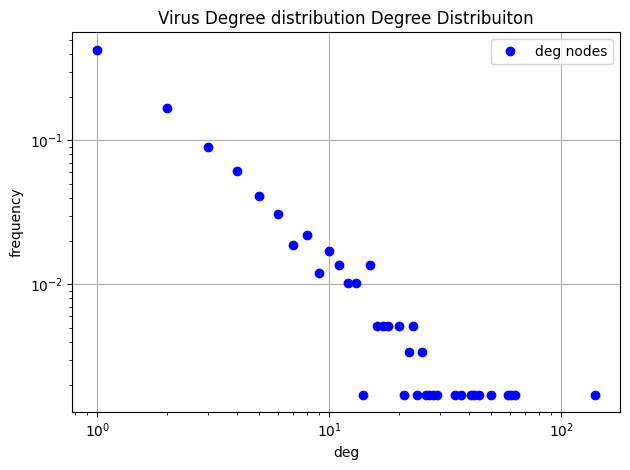

In [ ]:
network_statistics(typeA_nodes=len(adj_from_nodes),
                   typeB_nodes=len(adj_to_nodes),
                   adj_matrix=varius_host_adj_matrix)

print('#'*80)

plt_deg_distr(deg=varius_host_adj_matrix.sum(axis=0),
              title='Host Degree distribution',
              binned=False)

plt_deg_distr(deg=varius_host_adj_matrix.sum(axis=1),
              title='Virus Degree distribution',
              binned=False)

## Japanese mycorrhiza interactions

In [ ]:
path = '/content/drive/MyDrive/UCY Data /japanese_mycorrhiza_interactions.csv'
japan_plans = pd.read_csv(path)

In [ ]:
japan_plans.columns

Index(['OTU', 'OTU.code', 'kingdom', 'phylum', 'class', 'order', 'family',
       'genus', 'species', 'Guild', 'Taxon_Level', 'Trophic_Mode',
       'Growth_Morphology', 'Trait', 'Confidence_Ranking',
       'Category.In.This.Study', 'Nreads.TES', 'Nreads.TOMA', 'Nreads.YKS',
       'Nreads.SGD', 'Nreads.YSD', 'Nreads.YAKU', 'Nreads.YONA', 'Nreads.IRI',
       'Nreads.North', 'Nreads.South', 'Nreads.All', 'betweenness.ALL',
       'degree.ALL', 'closeness.ALL', 'eigenvector.centrality.ALL',
       'degree.North', 'closeness.North', 'eigenvector.centrality.North',
       'betweenness.North', 'degree.South', 'closeness.South',
       'eigenvector.centrality.South', 'betweenness.South',
       'betweenness.local.mean.ALL', 'betweenness.local.mean.North',
       'betweenness.local.mean.South', 'degree.TES', 'betweenness.TES',
       'eigenvector.centrality.TES', 'closeness.TES', 'degree.TOMA',
       'betweenness.TOMA', 'eigenvector.centrality.TOMA', 'closeness.TOMA',
       'degree.YKS', 

In [ ]:
japan_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8080 entries, 0 to 8079
Data columns (total 97 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OTU                                    8080 non-null   object 
 1   OTU.code                               8080 non-null   object 
 2   kingdom                                8080 non-null   object 
 3   phylum                                 8080 non-null   object 
 4   class                                  8080 non-null   object 
 5   order                                  8080 non-null   object 
 6   family                                 8080 non-null   object 
 7   genus                                  8080 non-null   object 
 8   species                                8080 non-null   object 
 9   Guild                                  8078 non-null   object 
 10  Taxon_Level                            8080 non-null   object 
 11  Trop

In [ ]:
for c in japan_plans.columns:
  print(f'{c}: {len(japan_plans[c].unique())}')

OTU: 8080
OTU.code: 8080
kingdom: 1
phylum: 6
class: 29
order: 82
family: 201
genus: 429
species: 288
Guild: 40
Taxon_Level: 5
Trophic_Mode: 9
Growth_Morphology: 20
Trait: 9
Confidence_Ranking: 4
Category.In.This.Study: 7
Nreads.TES: 352
Nreads.TOMA: 285
Nreads.YKS: 324
Nreads.SGD: 350
Nreads.YSD: 312
Nreads.YAKU: 366
Nreads.YONA: 336
Nreads.IRI: 381
Nreads.North: 694
Nreads.South: 754
Nreads.All: 1061
betweenness.ALL: 3287
degree.ALL: 138
closeness.ALL: 153
eigenvector.centrality.ALL: 3584
degree.North: 86
closeness.North: 174
eigenvector.centrality.North: 14
betweenness.North: 1319
degree.South: 106
closeness.South: 152
eigenvector.centrality.South: 14
betweenness.South: 2184
betweenness.local.mean.ALL: 2934
betweenness.local.mean.North: 1096
betweenness.local.mean.South: 2019
degree.TES: 19
betweenness.TES: 399
eigenvector.centrality.TES: 422
closeness.TES: 351
degree.TOMA: 18
betweenness.TOMA: 290
eigenvector.centrality.TOMA: 309
closeness.TOMA: 261
degree.YKS: 10
betweenness.YKS: 

## Humman Gene

In [ ]:
path = '/content/drive/MyDrive/UCY Data /Human_diseases_symptops/symproms_and_diseases.txt'
diases_df = pd.read_csv(path, sep="\t")


In [ ]:
diases_df.columns

Index(['MeSH Symptom Term', 'MeSH Disease Term', 'PubMed occurrence',
       'TFIDF score'],
      dtype='object')

In [ ]:
diases_adj_matrix, symptom_nodes, disease_nodes  = create_adj_matrix(df=diases_df,
                                                                      A='MeSH Symptom Term',
                                                                      B='MeSH Disease Term',
                                                                      edges=None)

From: 322
To: 4219


Building adjacency matrix: 100%|██████████| 147978/147978 [00:08<00:00, 18378.12it/s]


[INFO] Adj Matrix: (322, 4219)


+-----------------------+-----------------+
| Metric                |           Value |
+=======================+=================+
| # Top Nodes           |   4219          |
+-----------------------+-----------------+
| # Bottom Nodes        |    322          |
+-----------------------+-----------------+
| # Edges               | 147978          |
+-----------------------+-----------------+
| Top average degree    |    459.559      |
+-----------------------+-----------------+
| Bottom Average degree |     35.0742     |
+-----------------------+-----------------+
| Graph Average degree  |     65.1742     |
+-----------------------+-----------------+
| Density               |      0.108926   |
+-----------------------+-----------------+
| Sparsity              |      0.00717619 |
+-----------------------+-----------------+
################################################################################


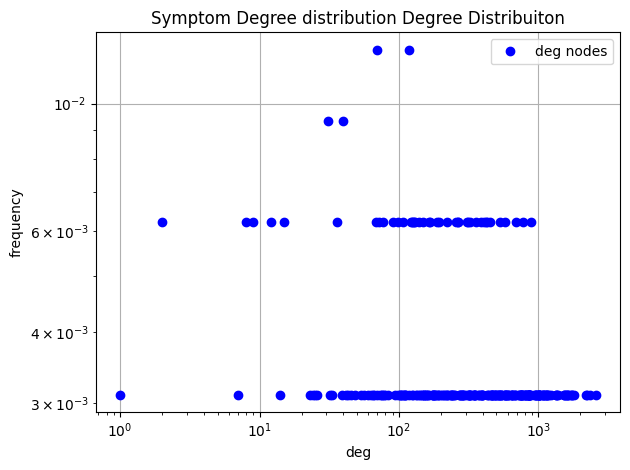

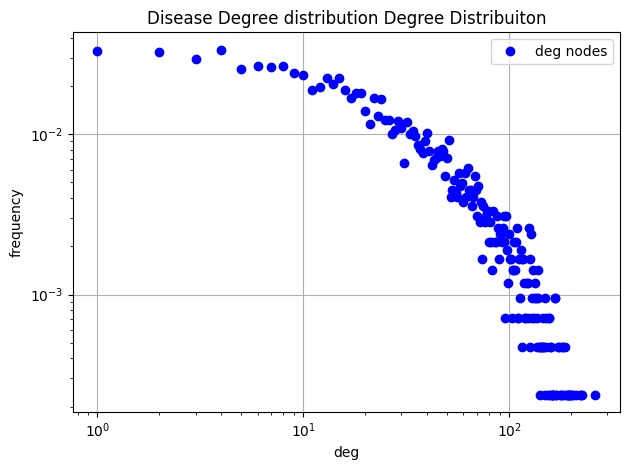

In [ ]:
network_statistics(typeA_nodes=len(symptom_nodes),
                   typeB_nodes=len(disease_nodes),
                   adj_matrix=diases_adj_matrix)

print('#'*80)
plt_deg_distr(deg=diases_adj_matrix.sum(axis=1),
              title='Symptom Degree distribution',
              binned=False)

plt_deg_distr(deg=diases_adj_matrix.sum(axis=0),
              title='Disease Degree distribution',
              binned=False)

## Host_pathogen


In [ ]:
path = '/content/drive/MyDrive/UCY Data /host_pathogen.csv'

In [ ]:
host_pathogen = pd.read_csv(path, sep=',', engine='python')

In [ ]:
host_pathogen.columns

Index(['Cargo', 'Cargo classification', 'Carrier', 'Carrier classification',
       'Sequences count', 'Publications count', 'Sequences', 'Publications'],
      dtype='object')

In [ ]:
host_pathogen_adj_matrix, cargo_nodes, carrier_nodes  = create_adj_matrix(df=host_pathogen,
                                                                      A='Cargo',
                                                                      B='Carrier',
                                                                      edges=None)

From: 8913
To: 6314


Building adjacency matrix: 100%|██████████| 22515/22515 [00:01<00:00, 18804.13it/s]


[INFO] Adj Matrix: (8913, 6314)


+-----------------------+----------------+
| Metric                |          Value |
+=======================+================+
| # Top Nodes           |  6314          |
+-----------------------+----------------+
| # Bottom Nodes        |  8913          |
+-----------------------+----------------+
| # Edges               | 22512          |
+-----------------------+----------------+
| Top average degree    |     2.5257     |
+-----------------------+----------------+
| Bottom Average degree |     3.5654     |
+-----------------------+----------------+
| Graph Average degree  |     2.9569     |
+-----------------------+----------------+
| Density               |     0.00040002 |
+-----------------------+----------------+
| Sparsity              |     9.709e-05  |
+-----------------------+----------------+
################################################################################


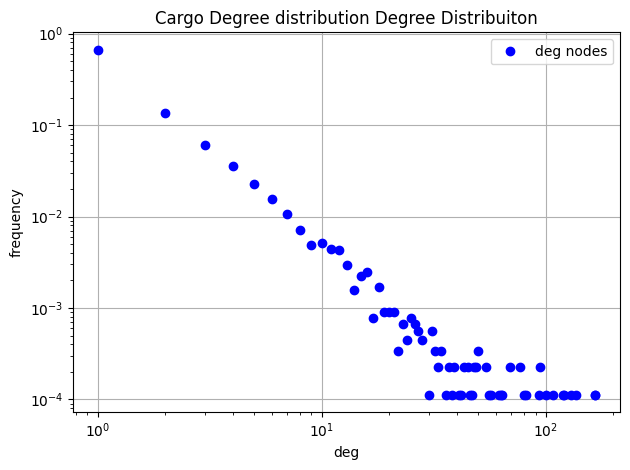

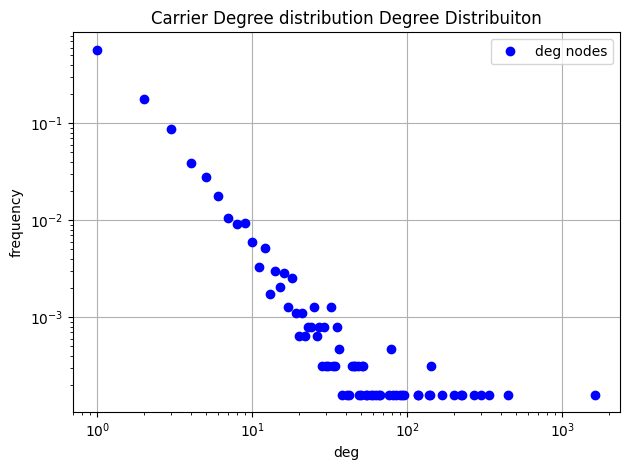

In [ ]:
network_statistics(typeA_nodes=len(cargo_nodes),
                   typeB_nodes=len(carrier_nodes),
                   adj_matrix=host_pathogen_adj_matrix)

print('#'*80)
plt_deg_distr(deg=host_pathogen_adj_matrix.sum(axis=1),
              title='Cargo Degree distribution',
              binned=False)

plt_deg_distr(deg=host_pathogen_adj_matrix.sum(axis=0),
              title='Carrier Degree distribution',
              binned=False)

## Nematode Mammal Interactions


In [ ]:
path = '/content/drive/MyDrive/UCY Data /nematode_mammal.csv'

In [ ]:
nematode_mammal = pd.read_csv(path, encoding='latin-1')

In [ ]:
nematode_mammal.columns


Index(['Unnamed: 0', 'Host', 'Parasite', 'ParasiteFull', 'group', 'locality',
       'hostgroup'],
      dtype='object')

In [ ]:
nematode_mammal_adj_matrix, host_nodes, parasite_nodes = create_adj_matrix(df=nematode_mammal,
                                                                      A='Host',
                                                                      B='Parasite',
                                                                      edges=None)

From: 11873
To: 18643


Building adjacency matrix: 100%|██████████| 146683/146683 [00:11<00:00, 12941.97it/s]


[INFO] Adj Matrix: (11873, 18643)


+-----------------------+----------------+
| Metric                |          Value |
+=======================+================+
| # Top Nodes           | 18643          |
+-----------------------+----------------+
| # Bottom Nodes        | 11873          |
+-----------------------+----------------+
| # Edges               | 61597          |
+-----------------------+----------------+
| Top average degree    |     5.188      |
+-----------------------+----------------+
| Bottom Average degree |     3.304      |
+-----------------------+----------------+
| Graph Average degree  |     4.037      |
+-----------------------+----------------+
| Density               |     0.00027828 |
+-----------------------+----------------+
| Sparsity              |     6.615e-05  |
+-----------------------+----------------+
################################################################################


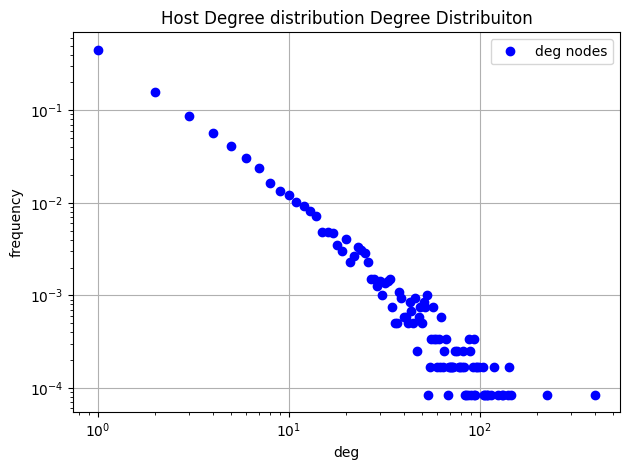

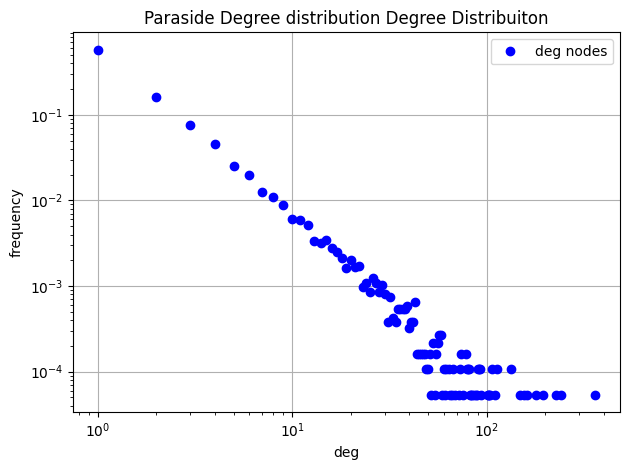

In [ ]:
network_statistics(typeA_nodes=len(host_nodes),
                   typeB_nodes=len(parasite_nodes),
                   adj_matrix=nematode_mammal_adj_matrix)

print('#'*80)
plt_deg_distr(deg=nematode_mammal_adj_matrix.sum(axis=1),
              title='Host Degree distribution',
              binned=False)

plt_deg_distr(deg=nematode_mammal_adj_matrix.sum(axis=0),
              title='Paraside Degree distribution',
              binned=False)

## Restaurnats NY check-ins 2013


In [ ]:
path = '/content/drive/MyDrive/UCY Data /foursquare_NY_restaurants/dataset_ubicomp2013_checkins.txt'
restaurant_df = pd.read_csv(path, sep="\t", header=None, names=['user ID', 'venue ID'])

In [ ]:
restaurant_adj_matrix, user_nodes, venue_nodes  = create_adj_matrix(df=restaurant_df,
                                                                      A='user ID',
                                                                      B= 'venue ID',
                                                                      edges=None)

From: 2060
To: 2876


Building adjacency matrix: 100%|██████████| 27149/27149 [00:01<00:00, 22516.26it/s]


[INFO] Adj Matrix: (2060, 2876)


+-----------------------+----------------+
| Metric                |          Value |
+=======================+================+
| # Top Nodes           |  2876          |
+-----------------------+----------------+
| # Bottom Nodes        |  2060          |
+-----------------------+----------------+
| # Edges               | 13472          |
+-----------------------+----------------+
| Top average degree    |     6.5398     |
+-----------------------+----------------+
| Bottom Average degree |     4.6843     |
+-----------------------+----------------+
| Graph Average degree  |     5.4587     |
+-----------------------+----------------+
| Density               |     0.00227392 |
+-----------------------+----------------+
| Sparsity              |     0.00055294 |
+-----------------------+----------------+
################################################################################


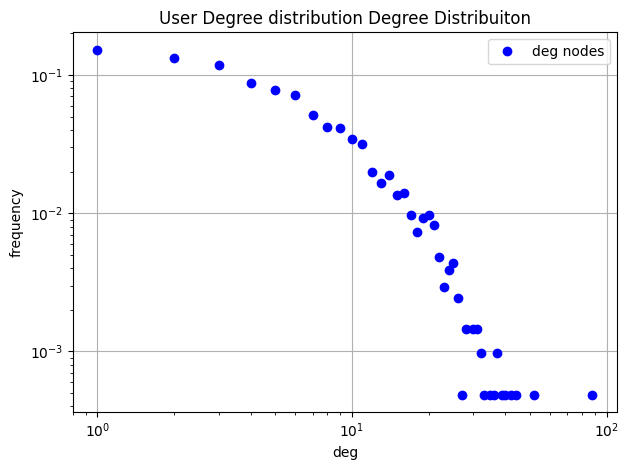

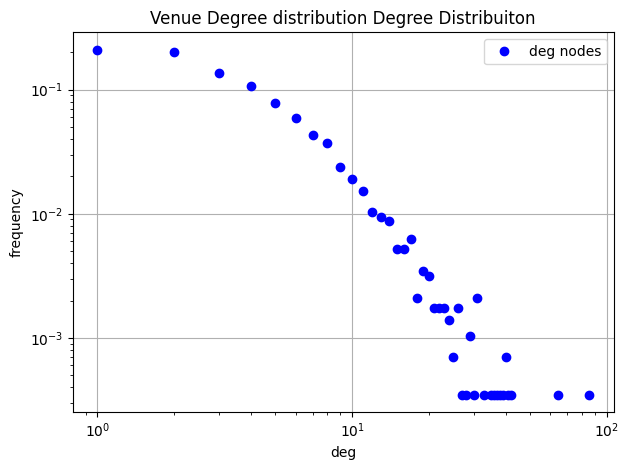

In [ ]:
network_statistics(typeA_nodes=len(user_nodes),
                   typeB_nodes=len(venue_nodes),
                   adj_matrix=restaurant_adj_matrix)

print('#'*80)
plt_deg_distr(deg=restaurant_adj_matrix.sum(axis=1),
              title='User Degree distribution',
              binned=False)

plt_deg_distr(deg=restaurant_adj_matrix.sum(axis=0),
              title='Venue Degree distribution',
              binned=False)

## Restaurants NYC Tokyo 2014

In [ ]:
path_tky = '/content/drive/MyDrive/UCY Data /foursquare_NY_Tokyo_restaurants_2014/dataset_TSMC2014_TKY.txt'
path_nyc = '/content/drive/MyDrive/UCY Data /foursquare_NY_Tokyo_restaurants_2014/dataset_TSMC2014_NYC.txt'

In [ ]:
columns = [ "user ID", "venue ID", "venue category ID", "venue category name",
    "latitude", "longitude", "timezone offset", "UTC time"]
#read files
restaurant_tky_df = pd.read_csv( path_tky, sep="\t", header=None, names=columns, encoding="latin1" )
restaurant_nyc_df = pd.read_csv( path_nyc, sep="\t", header=None, names=columns, encoding="latin1" )
# map tokyo and nyc
restaurant_tky_df["city"] = "TKY"
restaurant_nyc_df["city"] = "NYC"
# merge
restaurant_all_df = pd.concat([restaurant_tky_df, restaurant_nyc_df], ignore_index=True)


In [ ]:
restaurant_all_adj_matrix, user_nodes_all, venue_nodes_all  = create_adj_matrix(df=restaurant_all_df,
                                                                      A='user ID',
                                                                      B= 'venue ID',
                                                                      edges=None)


From: 2293
To: 100191


Building adjacency matrix: 100%|██████████| 801131/801131 [00:51<00:00, 15610.60it/s]



[INFO] Adj Matrix: (2293, 100191)


+-----------------------+----------------+
| Metric                |          Value |
+=======================+================+
| # Top Nodes           | 100191         |
+-----------------------+----------------+
| # Bottom Nodes        |   2293         |
+-----------------------+----------------+
| # Edges               | 302979         |
+-----------------------+----------------+
| Top average degree    |    132.132     |
+-----------------------+----------------+
| Bottom Average degree |      3.024     |
+-----------------------+----------------+
| Graph Average degree  |      5.9127    |
+-----------------------+----------------+
| Density               |      0.0013188 |
+-----------------------+----------------+
| Sparsity              |      2.885e-05 |
+-----------------------+----------------+
################################################################################


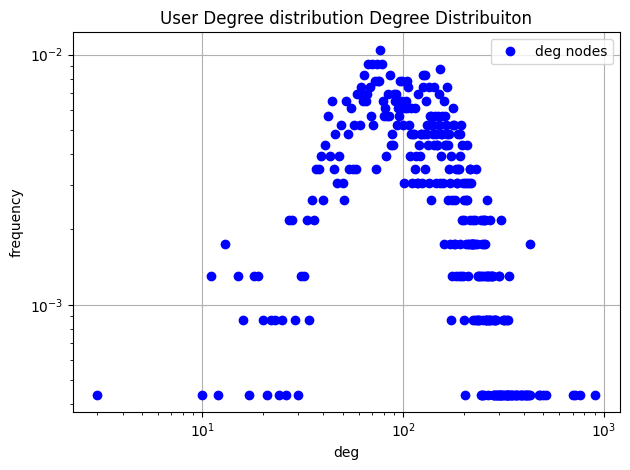

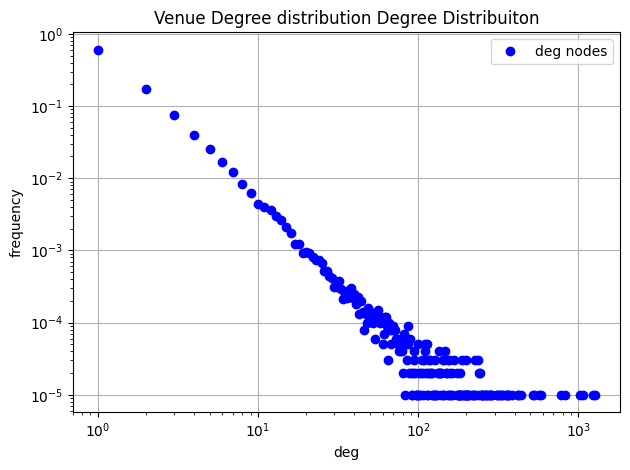

In [ ]:
network_statistics(typeA_nodes=len(user_nodes_all),
                   typeB_nodes=len(venue_nodes_all),
                   adj_matrix=restaurant_all_adj_matrix)

print('#'*80)
plt_deg_distr(deg=restaurant_all_adj_matrix.sum(axis=1),
              title='User Degree distribution',
              binned=False)

plt_deg_distr(deg=restaurant_all_adj_matrix.sum(axis=0),
              title='Venue Degree distribution',
              binned=False)